In [ ]:
# Automatic Speech Recognition using CTC

## Introduction
Speech recognition is an interdisciplinary subfield of computer science
and computational linguistics that develops methodologies and technologies
that enable the recognition and translation of spoken language into text
by computers. It is also known as automatic speech recognition (ASR),
computer speech recognition or speech to text (STT). It incorporates
knowledge and research in the computer science, linguistics and computer
engineering fields.

This demonstration shows how to combine a 2D CNN, RNN and a Connectionist
Temporal Classification (CTC) loss to build an ASR. CTC is an algorithm
used to train deep neural networks in speech recognition, handwriting
recognition and other sequence problems. CTC is used when  we don’t know
how the input aligns with the output (how the characters in the transcript
align to the audio). The model we create is similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

We will use the LJSpeech dataset from the
[LibriVox](https://librivox.org/) project. It consists of short
audio clips of a single speaker reading passages from 7 non-fiction books.

We will evaluate the quality of the model using
[Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate).
WER is obtained by adding up
the substitutions, insertions, and deletions that occur in a sequence of
recognized words. Divide that number by the total number of words originally
spoken. The result is the WER. To get the WER score you need to install the
[jiwer](https://pypi.org/project/jiwer/) package. You can use the following command line:

```
pip install jiwer
```

**References:**

- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)
- [Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)
- [DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)

In [1]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


Jewer is specialized library for evaluating automatic speech recognition system, primary focusing on Word Error Rate and related metrics

Ipython is advanced interactive shell for python that enhanches productivity with features like magic commands, rich media support, and integration with jupyter notebook. It is widely used in data science and research for its powerful interactive capabilities.

## Load the LJSpeech Dataset

Let's download the [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/).
The dataset contains 13,100 audio files as `wav` files in the `/wavs/` folder.
The label (transcript) for each audio file is a string
given in the `metadata.csv` file. The fields are:

- **ID**: this is the name of the corresponding .wav file
- **Transcription**: words spoken by the reader (UTF-8)
- **Normalized transcription**: transcription with numbers,
ordinals, and monetary units expanded into full words (UTF-8).

For this demo we will use on the "Normalized transcription" field.

Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

In [3]:
'''
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

'''


'\ndata_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"\ndata_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)\nwavs_path = data_path + "/wavs/"\nmetadata_path = data_path + "/metadata.csv"\n\n'

Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_path = '/content/drive/My Drive/LJSpeech-1.1'
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


In [6]:


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)


,file_name,normalized_transcription
0,LJ028-0272,"All stratagems and all arts had been used, and..."
1,LJ018-0055,"He is described as not a bad-looking man, with..."
2,LJ023-0019,and to cure the abuses and the inequalities wh...


We now split the data into training and validation set.

In [7]:
split = int(len(metadata_df) * 0.9)
df_train = metadata_df[ : split]
df_val = metadata_df[split : ]

print(f'Size of training set is {len(df_train)}')
print(f"Size of testing set is {len(df_val)}")

Size of training set is 11790
Size of testing set is 1310


##Preprocessing

We first prepare all the vocabulary that could be used

In [8]:
#the set of character accepted in the transcription
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

#mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary= characters, oov_token= "")

#mapping integers to characters
num_to_char = keras.layers.StringLookup(vocabulary= char_to_num.get_vocabulary(), oov_token="", invert = True)

print(f"the vocabulary is: {char_to_num.get_vocabulary()} \n"  f"The size is {char_to_num.vocabulary_size()}")

the vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] 
The size is 31


Next, we create the function that describes the transformation that we apply to each element of our dataset.

In [9]:
# integer scalar in Tensor, the window length in sample
frame_length = 256

#integer scalar in Tensor, the number of samples to step
frame_step = 160

#integer scalar in Tensor, the size of fft to apply
#if not provided then it uses smallest power of 2 enclosing frame length
fft_length = 384

def encode_single_sample(wav_file, label):

  #process the audio
  # 1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  #2. Decode wav file
  audio, _ = tf.audio.decode_wav(file)      #decode the file
  audio = tf.squeeze(audio, axis= -1)       #squeeze reduce the unnecessary dimension
  #3. change type to float
  audio = tf.cast(audio, tf.float32)
  #4. get the spectrogram
  spectrogram = tf.signal.stft(audio, frame_length= frame_length, frame_step= frame_step, fft_length= fft_length)
            #stft short term frequency spectrum is like dtft where we transform the data into frequency domain,
            #stft has smaller time frames, the frequency spectrum moves smoother overtime so is more accurate
  #5. we only need magnitude which can be derived by applying abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  #6. Normalization
  means= tf.math.reduce_mean(spectrogram, 1, keepdims= True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims= True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  #process the label
  #7. convert the label to lower case
  label = tf.strings.lower(label)
  #8. split the label
  label = tf.strings.unicode_split(label, input_encoding= "UTF-8")
  #9. maps character in label to number
  label = char_to_num(label)
  #10. Return a dict as our model is expecting two inputs
  return spectrogram, label

##Creating Dataset Object

we create tf.data.dataset object that yields the transformed elements, in the same order as they appear in the input

Description of functions used:

map is used to apply the function to all the elements.
here we apply encode_single_sample function to all the elements of train_dataset


num_parallel_calls = tf.data.AUTOTUNE :- allows tensorflow to automatically tune or use the number of parallel calls to map the function,
used to increase the performance

padded_batch :- add the number 0 to all the missing value

prefetching :- is used to load the data for next batch where the current batch is processing by model
  prefetch(buffer_size = tf.data.AUTOTUNE) :- is used to automatically tune the prefetch bufersize for optimal performance

In [10]:
batch_size= 32
#define the training element
train_dataset= tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls= tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

#Define the validataion dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls= tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

##Visualize the data

Let's visualize an example in our dataset, including the audioclip, the spectrogram and the corresponding label

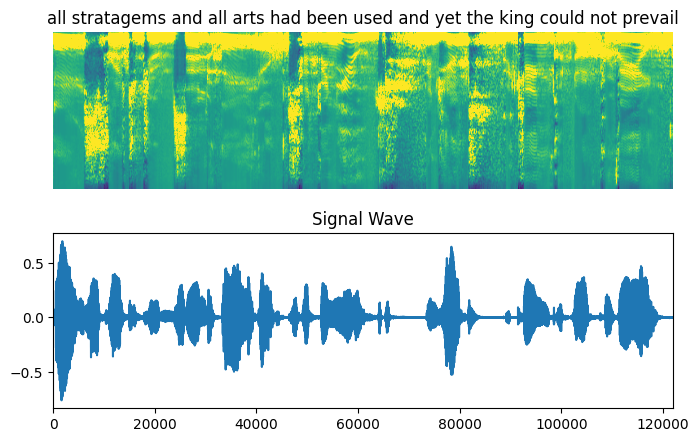

In [11]:
fig = plt.figure(figsize= (8, 5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]

   # process the label
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

  #plot the spectogram
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax= 1)
  ax.set_title(label)
  ax.axis("off")

  # plot and decode wav file, read the first audio from the dataset, and convert the audio tensor to numpy
  file= tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = audio.numpy()

  #plot the audio signal
  ax= plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))

  #display the audio player, ipython's display module to provide an audio player for audio signal
  display.display(display.Audio(np.transpose(audio), rate = 16000))
plt.show()

## Model

We first define the CTC Loss function

In [12]:
def CTCLoss(y_true, y_pred):
  #compute the training time loss value
  batch_len = tf.cast(tf.shape(y_true)[0], dtype= "int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype= "int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype= "int64")

  input_length = input_length * tf.ones(shape= (batch_len, 1), dtype= "int64")
  label_length = label_length * tf.ones(shape= (batch_len, 1), dtype= "int64")

  loss= keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [13]:
def build_model(input_dim, output_dim, rnn_layers= 5, rnn_units= 128):

  #Model input
  input_spectrogram = layers.Input((None, input_dim), name= "input")  #accepts input spectrogram with shape (None, input_dim) where None dimension allows for variable sequence length
  """Expand the dimension using 2D CNN
  here we are adding additional dimension of channel, -1 means keeping original input size same, input_dim means number of frequency_bins and 1 means added channel dimension
  here we are reshaping because 2D Convolution layer has 4 dimensions ie. batch_size, height, weight and channels

  here we are dealing with 2D CNN and spectrogram, so we put channel value as 1

  in higher channel values the input data carries individual channel data and the input data of all individual channel is merged while passing input.
  But while passing in CNN we separate the data according to channel and extract the information
  """
  x = layers.Reshape((-1, input_dim, 1), name= "expand_dim")(input_spectrogram)

  #Convolution layer 1
  x= layers.Conv2D(
      filters= 32,            #each filter will have distinct value, so that after convolution we can get 32 features like edges, textures, pattern, etc. and the size of each filter is of kernel size
      kernel_size= [11, 41],  #size of the filter to convolute with input data
      strides= [2, 2],        #how much filter moves at each steps during convolution
      padding= "same",        #padding is how model handle boarder input, two types: 1. Valid:- No Padding       2. Same:- padding is addes so that output dimesion is same as input dimension(assuming stride=1)
      use_bias= False,
      name = "conv_1",
  )(x)
  x= layers.BatchNormalization(name= "conv_1_bn")(x)
  x= layers.ReLU(name= "conv_1_relu")(x)
  """the purpose of bias is to learn the complex data pattern by shifting activation function so that data can fit well. but while using batch normalization use_bias is set false,
       because of redundancy and less number of parameter which leads slightly to fast computation an less memory usage.
       Without BatchNorm:
            Conv Layer:  z=w⋅x+b
            Activation:  y=f(z)
      With BatchNorm:
            Conv Layer: z=w⋅x (no bias term)
            BatchNorm: z ^ = σ z−μ ​ (normalize)
            BatchNorm: y=γ z ^ +β (scale and shift)

      In the second case, BatchNormalization normalizes the output of the convolutional layer and then applies its own shift (beta), making the bias term in the convolutional layer unnecessary.
      """

  #Convolution layer 2
  x = layers.Conv2D(
      filters= 32,
      kernel_size= [11, 21],
      strides= [1, 2],
      padding= "same",
      use_bias= False,
      name= "conv_2"
  )(x)
  x= layers.BatchNormalization(name= "conv_2_bn")(x)
  x= layers.ReLU(name= "conv_2_relu")(x)

  #Reshape the resulted volume to feed RNN's layer
  x= layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  """
  The shape of x at this point is typically [batch_size, time_steps, frequency_bins, channels].
  Recurrent neural networks (RNNs), including GRUs and LSTMs, typically expect input data to have three dimensions:
    Batch size: The number of sequences in a batch.
    Time steps: The number of time steps in each sequence.
    Features: The number of features at each time step

  x.shape[-2]: This refers to the frequency dimension of x.
  x.shape[-1]: This refers to the channel dimension of x.

  For example:

    batch_size = 32
    time_steps = 100
    frequency_bins = 64
    channels = 32
    So, the shape of x would be [32, 100, 64, 32].

    The reshape operation:
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    will change the shape to [batch_size, time_steps, frequency_bins * channels].

    For our example:
    frequency_bins * channels = 64 * 32 = 2048
    So, the new shape of x would be [32, 100, 2048].

    This reshaped output can now be fed into the RNN layers, which will interpret the last dimension (2048) as the feature dimension.
  """

  #RNN layer
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units= rnn_units,
        activation= "tanh",
        recurrent_activation= "sigmoid",
        use_bias= True,
        return_sequences= True,
        reset_after= True,
        name= f"gru_{i}"
    )
    x= layers.Bidirectional(
        recurrent, name= f"bidirectional_{i}", merge_mode= "concat"
    )(x)
    if i < rnn_layers:
      x = layers.Dropout(rate= 0.5)(x)

  #Dense layer
  x= layers.Dense(units= rnn_units * 2, name= "dense_1")(x)  #this is fully connected layer having double the number of neuron of rnn in hidden layer
  x= layers.ReLU(name= "dense_1_relu")(x)
  x= layers.Dropout(rate= 0.5)(x)    #this is for regularization, as 50 percent of the neuron is temporarily deleted or not used, we give value 0 during forward and backward propagation

  #Classification layer
  output= layers.Dense(units= output_dim + 1, activation= "softmax")(x)

  #Model
  model= keras.Model(input_spectrogram, output, name= "DeepSearch_2")

  #Optimizer
  opt= keras.optimizers.Adam(learning_rate= 1e-4)

  #Compile the model and return
  model.compile(optimizer= opt, loss= CTCLoss)
  return model


In [14]:
#get the model
model = build_model(
    input_dim= fft_length // 2 + 1,
    output_dim= char_to_num.vocabulary_size(),
    rnn_units= 512,
)

In [15]:

model.summary(line_length= 110)

Model: "DeepSearch_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [16]:
#a utility function to decode the output of the network
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  #using greedy search. we can use beam search for complex task
  results= keras.backend.ctc_decode(pred, input_length= input_len, greedy= True)[0][0]
  #Iterate over the results and get back the text
  output_text = []
  for result in results:
    result= tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text


In [17]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


Training process

In [ ]:
epochs= 1
#callback function to check transcription on the val set
validation_callback= CallbackEval(validation_dataset)
#train the model
history= model.fit(
    train_dataset,
    validation_data= validation_dataset,
    epochs= epochs,
    callbacks= [validation_callback],
)

176/369 [=============>................] - ETA: 11:45:23 - loss: 329.7732

#Inference

In [ ]:
#let's check result on more validation samples
